In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import operator

from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.random.seed(1907)

df = pd.read_csv("cell2cell-v1.csv")
df.dropna(inplace= True)

df= df.drop('Unnamed: 0', axis = 1)
df= df.drop('X', axis = 1)
df= df.drop('customer', axis = 1)
df= df.drop('traintest', axis = 1)
df= df.drop('churn', axis = 1)
df= df.drop('churndep', axis = 1)
df= df.drop('recchrge', axis = 1)

df = pd.get_dummies(df)

labels = np.array(df['revenue'])
#df= df.drop('revenue', axis = 1)

#df['constant']=1
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.25, random_state = 42)

train_x = train_x.drop('revenue', axis = 1)
test_x = test_x.drop('revenue', axis = 1)


Bad key text.latex.unicode in file D:\Users\okaltun\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file D:\Users\okaltun\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file D:\Users\okaltun\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably

## FLOW:

Here, I have an available Churn data to analyse, build models on and predict. However, another interesting problem might be deriven from this dataset: estimating monthly revenue from the customer. To do that I will build a regression with OLS estimator, examine pairwise correlations and multi-collinearity, and examine interactions between variables.

In [3]:
categorical = [
    'children', 'credita', 'creditaa', 'prizmrur', 'prizmub', 'prizmtwn',
    'refurb', 'webcap', 'truck', 'rv', 'occprof', 'occcler', 'occcrft',
    'occstud', 'occhmkr', 'occret', 'occself', 'ownrent', 'marryun',
    'marryyes', 'mailord', 'mailres', 'mailflag', 'travel', 'pcown',
    'creditcd', 'newcelly', 'newcelln', 'incmiss', 'mcycle', 'setprcm',
    'retcall', 'mcycle', 'setprcm', 'retcall'
]

continuous =  [
    'mou', 'directas', 'overage', 'roam', 'changem', 'changer', 'dropvce',
    'blckvce', 'unansvce', 'custcare', 'threeway', 'mourec', 'outcalls',
    'incalls', 'peakvce', 'opeakvce', 'dropblk', 'callfwdv', 'callwait',
    'months', 'uniqsubs', 'actvsubs', 'phones', 'models', 'eqpdays', 'age1',
    'age2', 'retcalls', 'retaccpt', 'refer', 'income', 'setprc', 'income',
    'setprc'
]

#### Functions to be used:

In [4]:
def pairwise_correlation(all_data, train_data):
    corr_df = train_data.corr()
    corr_w_target = all_data.corr().drop('revenue',axis=1).loc['revenue']
    
    final = pd.DataFrame(columns=['v1','v2','corr','t1','t2'])
    for col1 in corr_df.columns:
        serie = corr_df.loc[col1]
        corr_df.drop(col1,axis=1,inplace=True)
        for col2 in corr_df.columns:
            corr = abs(serie[col2])
            corr1 = abs(corr_w_target[col1])
            corr2 = abs(corr_w_target[col2])
            final.loc[len(final)] =[col1,col2,corr,corr1,corr2]
    en_son = final.sort_values(by='corr',ascending = False).reset_index(drop=True)
    en_son.to_pickle('pairwise_correlation.pkl')
    return en_son

In [5]:
def standardize(train_x,test_x,train_y,test_y,continuous):
    scaler = preprocessing.StandardScaler()
    train_x[continuous] = scaler.fit_transform(train_x[continuous])
    test_x[continuous] = scaler.transform(test_x[continuous])
    
    #train_y[continuous] = scaler.fit_transform(train_y[continuous])
    #test_y[continuous] = scaler.transform(test_y[continuous])
    
    train_x['const'] = 1
    test_x['const'] = 1

In [6]:
def OLS(train_x, test_x, train_y, test_y, selected = train_x.columns):

    ols_regression=sm.OLS(train_y, train_x[selected], missing='drop').fit()
    ols_pred = ols_regression.predict(test_x[selected].values)
    print(ols_regression.summary())
    print('mse: '+ str(mean_squared_error(test_y, ols_pred)))

In [7]:
def visual_poly(train_x, train_y, variable):
    for i in [1,2,3]:
        print('Degree: ' + str(i))
        x = np.array(train_x[variable])[:, np.newaxis]
        y = train_y[:, np.newaxis]

        if i==1:
            x_poly = x
        else:
            polynomial_features= PolynomialFeatures(degree=i)
            x_poly = polynomial_features.fit_transform(x)


        model = LinearRegression()
        model.fit(x_poly, y)
        y_poly_pred = model.predict(x_poly)

        mse = mean_squared_error(y,y_poly_pred)
        r2 = r2_score(y,y_poly_pred)
        print('rmse: '+str(mse))
        print('r2: '+str(r2))

        plt.scatter(x, y, s=10)
        # sort the values of x before line plot
        sort_axis = operator.itemgetter(0)
        sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
        x, y_poly_pred = zip(*sorted_zip)
        plt.plot(x, y_poly_pred, color='m')
        plt.show()

        print(model.intercept_)
        print(model.coef_)

In [8]:
def RFE_Elimination(train_x, train_y, remain, selected = train_x.columns):

    lr = LinearRegression()
    lr.fit(train_x, train_y)

    rfe = RFE(lr, remain)             
    rfe = rfe.fit(train_x, train_y)
    
    return list(train_x.columns[rfe.ranking_<=remain])

### Standardize:

In [9]:
standardize(train_x,test_x,train_y,test_y,continuous)

### OLS Trial with ALL Variables:

In [10]:
OLS(train_x, test_x, train_y, test_y, selected = train_x.columns)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     1638.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:05:01   Log-Likelihood:            -1.2928e+05
No. Observations:               29205   AIC:                         2.587e+05
Df Residuals:                   29140   BIC:                         2.592e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mou           12.7626      0.276     46.169      0.0

#### Pearwise Correlation Elimination:

In [11]:
corr_df = pairwise_correlation(df, train_x.copy().drop('const',axis=1))

eliminate_df = corr_df[corr_df['corr']>0.7].reset_index()

drop_list=[]
for i in range(0,len(eliminate_df)):
    v1 = eliminate_df.iloc[i]['v1']
    v2 = eliminate_df.iloc[i]['v2']
    t1 = eliminate_df.iloc[i]['t1']
    t2 = eliminate_df.iloc[i]['t2']
    
    if (t1>t2) and (v1 not in drop_list):
        drop_list = drop_list + [v1]
    elif (t1<=t2) and (v2 not in drop_list):
        drop_list = drop_list + [v2]

selected_not_corr = [x for x in train_x.columns if x not in drop_list]

In [12]:
OLS(train_x, test_x, train_y, test_y, selected = selected_not_corr)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     1745.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:05:13   Log-Likelihood:            -1.3225e+05
No. Observations:               29205   AIC:                         2.646e+05
Df Residuals:                   29158   BIC:                         2.650e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
directas       6.6724      0.142     46.841      0.0

#### Polynomial Control of Variables:

directas
Degree: 1
rmse: 1562.1642579976824
r2: 0.17103472210426296


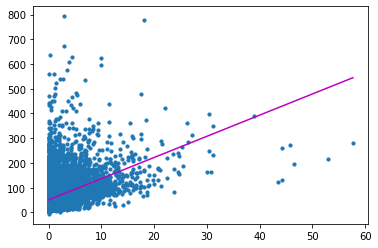

[51.00769262]
[[8.56017025]]
Degree: 2
rmse: 1531.423442222519
r2: 0.1873473913778917


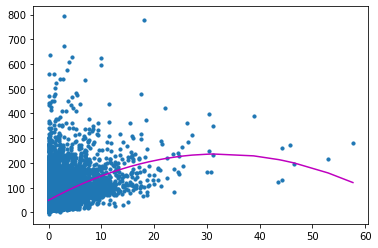

[49.2605026]
[[ 0.         11.59638372 -0.17954853]]
Degree: 3
rmse: 1524.9450437437943
r2: 0.19078516520208544


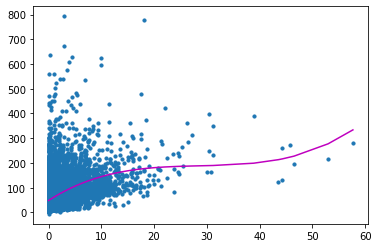

[48.41894025]
[[ 0.00000000e+00  1.37320696e+01 -4.62826367e-01  5.38443019e-03]]
overage
Degree: 1
rmse: 709.8100238277392
r2: 0.623338032064734


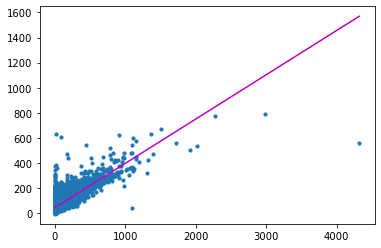

[44.32066812]
[[0.35310381]]
Degree: 2
rmse: 655.9667025546121
r2: 0.6519100875022446


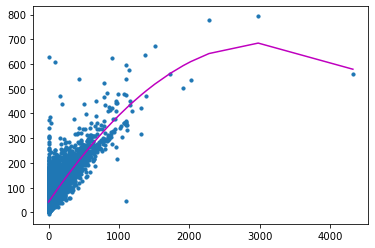

[42.43641033]
[[ 0.00000000e+00  4.18519612e-01 -6.81266490e-05]]
Degree: 3
rmse: 655.8784448671266
r2: 0.6519569216031134


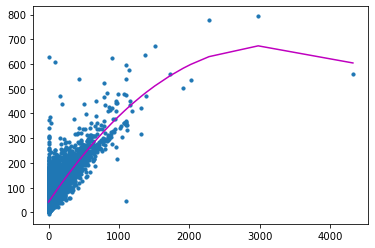

[42.34867378]
[[ 0.00000000e+00  4.22745303e-01 -7.75554099e-05  2.27118535e-09]]
roam
Degree: 1
rmse: 1762.926188967115
r2: 0.06450004174339175


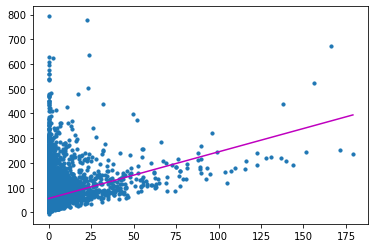

[56.36533152]
[[1.88681668]]
Degree: 2
rmse: 1757.350217233575
r2: 0.06745894118944451


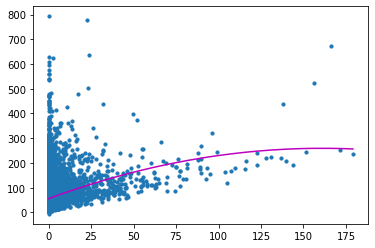

[55.90005395]
[[ 0.          2.52838657 -0.00785622]]
Degree: 3
rmse: 1748.120488061407
r2: 0.07235671360290086


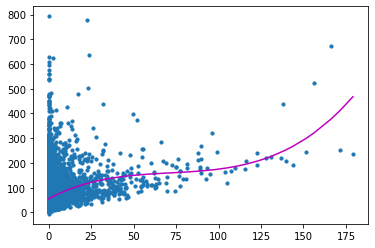

[55.32923549]
[[ 0.00000000e+00  3.67094166e+00 -4.63416638e-02  2.16113883e-04]]
changem
Degree: 1
rmse: 1883.6153618956516
r2: 0.0004561146957026141


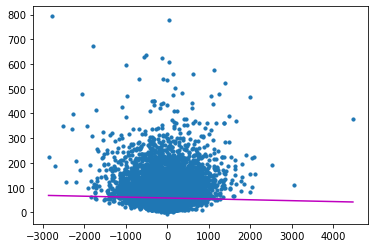

[58.5000328]
[[-0.00360034]]
Degree: 2
rmse: 1658.1962250340796
r2: 0.1200751857855672


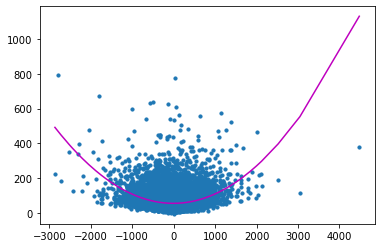

[55.01423799]
[[0.00000000e+00 8.37093873e-04 5.33857851e-05]]
Degree: 3
rmse: 1642.7545349456539
r2: 0.1282693464506811


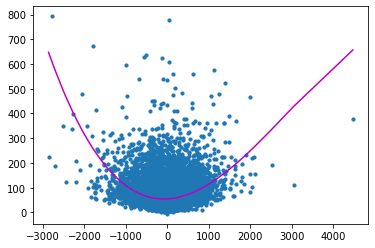

[54.87057984]
[[ 0.00000000e+00  9.27328172e-03  5.68019792e-05 -6.44451922e-09]]
changer
Degree: 1
rmse: 1883.9889340586592
r2: 0.0002578779543764842


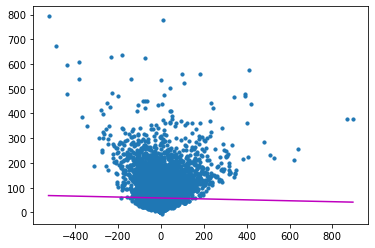

[58.53518457]
[[-0.01874965]]
Degree: 2
rmse: 1579.5109031034424
r2: 0.16182969362724053


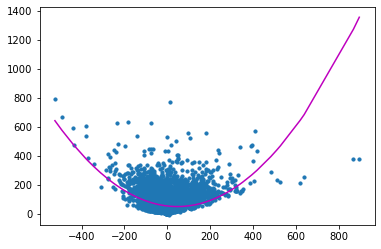

[55.87527255]
[[ 0.         -0.17147032  0.0018144 ]]
Degree: 3
rmse: 1430.0637047912885
r2: 0.24113411865509682


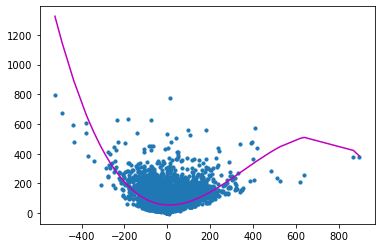

[54.63676073]
[[ 0.00000000e+00 -5.86940185e-02  3.02644189e-03 -2.84656126e-06]]
blckvce
Degree: 1
rmse: 1777.7316791984354
r2: 0.05664348167862587


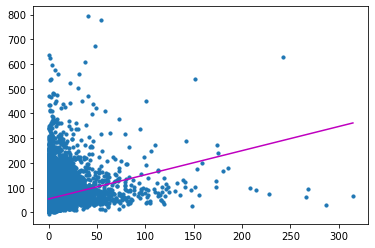

[54.59901238]
[[0.97623524]]
Degree: 2
rmse: 1747.5420974779038
r2: 0.07266363760806327


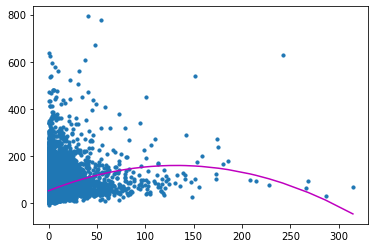

[52.75506706]
[[ 0.          1.62675406 -0.00616149]]
Degree: 3
rmse: 1733.1247627556015
r2: 0.08031422225266904


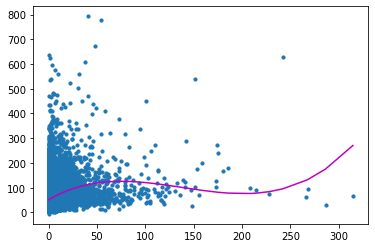

[51.42139574]
[[ 0.00000000e+00  2.26418639e+00 -2.06804730e-02  4.98932823e-05]]
unansvce
Degree: 1
rmse: 1469.9205011616732
r2: 0.2199840378552974


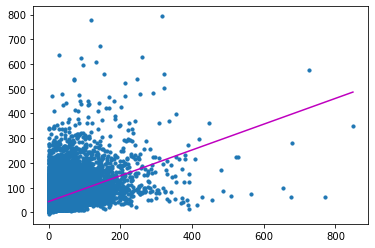

[43.90830939]
[[0.52158218]]
Degree: 2
rmse: 1438.1240718395595
r2: 0.23685687035940484


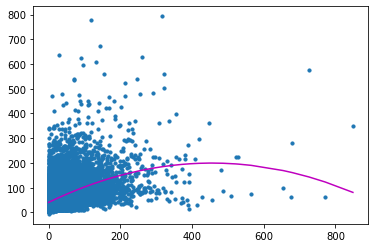

[40.73113808]
[[ 0.          0.69782575 -0.00076614]]
Degree: 3
rmse: 1429.3596857542882
r2: 0.24150770762543916


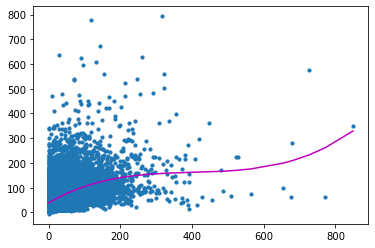

[38.8739334]
[[ 0.00000000e+00  8.40583331e-01 -1.99439210e-03  1.65784009e-06]]
custcare
Degree: 1
rmse: 1828.6966966610491
r2: 0.029598803343705682


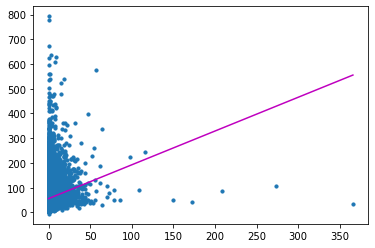

[56.09499616]
[[1.36539952]]
Degree: 2
rmse: 1797.9997777218744
r2: 0.04588817868223283


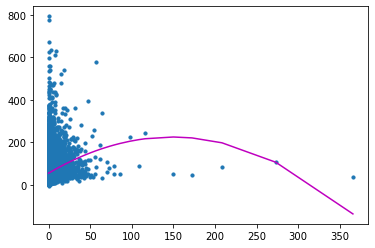

[54.68834815]
[[ 0.          2.28825023 -0.00769223]]
Degree: 3
rmse: 1788.6716450215226
r2: 0.050838169105203335


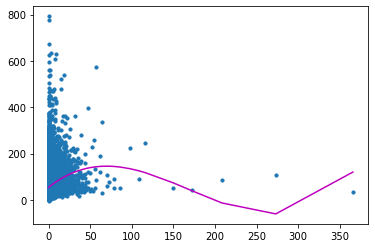

[54.05308684]
[[ 0.00000000e+00  2.87379147e+00 -2.59119402e-02  5.07226447e-05]]
threeway
Degree: 1
rmse: 1796.8585593681923
r2: 0.046493768257628854


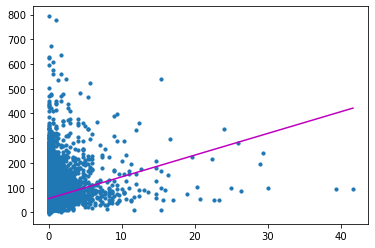

[56.05112248]
[[8.77686562]]
Degree: 2
rmse: 1766.145838048566
r2: 0.06279152915781205


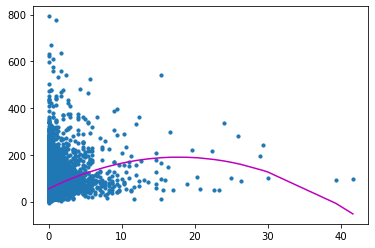

[54.73620772]
[[ 0.         15.21368965 -0.42699443]]
Degree: 3
rmse: 1758.285663677605
r2: 0.06696254484862318


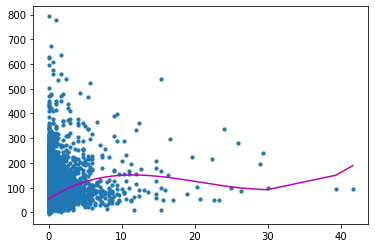

[54.12905528]
[[ 0.00000000e+00  1.93272705e+01 -1.15679196e+00  1.85023674e-02]]
incalls
Degree: 1
rmse: 1587.4691963824823
r2: 0.15760661096108675


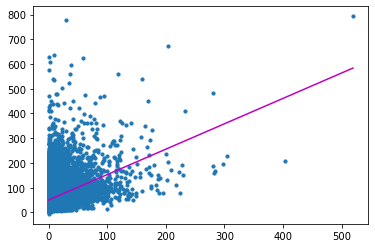

[50.30350955]
[[1.02666248]]
Degree: 2
rmse: 1581.0951907315327
r2: 0.1609889885431477


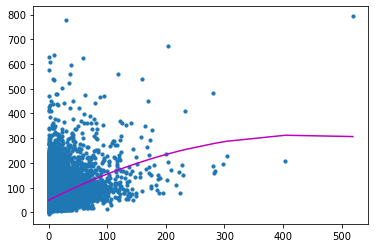

[49.44675561]
[[ 0.          1.1909931  -0.00133903]]
Degree: 3
rmse: 1561.0760849124138
r2: 0.17161216311240912


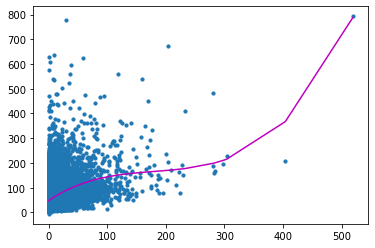

[47.88886341]
[[ 0.00000000e+00  1.59775766e+00 -7.83766162e-03  1.44530248e-05]]
callfwdv
Degree: 1
rmse: 1884.3988253430475
r2: 4.036840585708301e-05


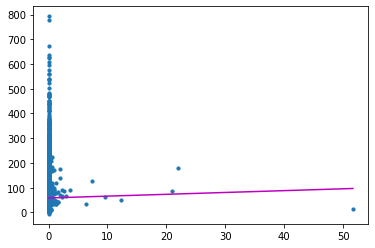

[58.54821724]
[[0.74202055]]
Degree: 2
rmse: 1883.6214510506304
r2: 0.0004528834746428956


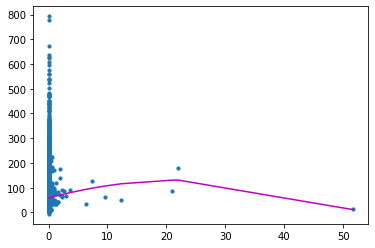

[58.52667121]
[[ 0.          6.40587905 -0.14157382]]
Degree: 3
rmse: 1883.5449565431347
r2: 0.0004934754228577143


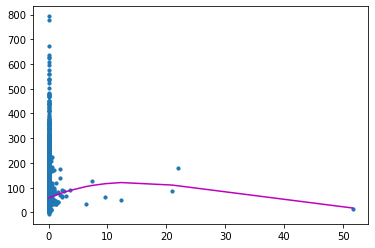

[58.51782426]
[[ 0.00000000e+00  9.96245857e+00 -4.57364251e-01  4.82546638e-03]]
callwait
Degree: 1
rmse: 1436.4556310720827
r2: 0.23774223145852302


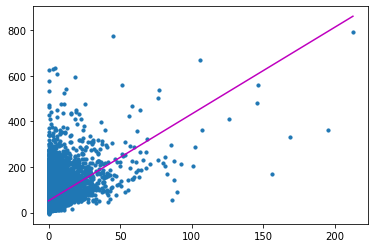

[51.65101208]
[[3.81147502]]
Degree: 2
rmse: 1394.620771075456
r2: 0.25994197528525975


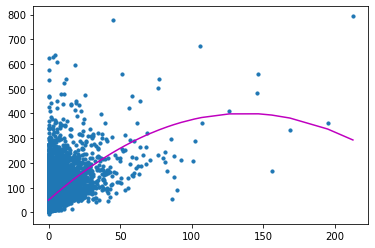

[49.91544414]
[[ 0.          5.12234686 -0.01871145]]
Degree: 3
rmse: 1362.5112711467207
r2: 0.2769809392707978


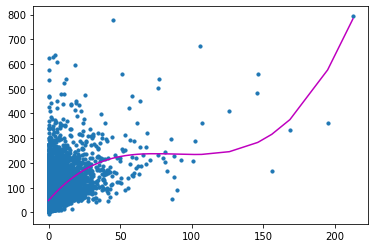

[48.39428097]
[[ 0.00000000e+00  6.71883842e+00 -7.80711792e-02  2.94840492e-04]]
months
Degree: 1
rmse: 1884.045924555327
r2: 0.00022763584464580155


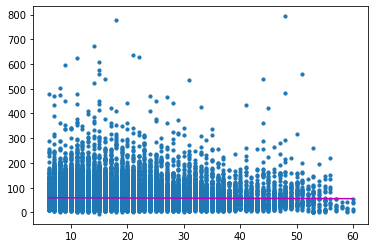

[59.83958]
[[-0.06840412]]
Degree: 2
rmse: 1882.6753371205211
r2: 0.0009549405361706231


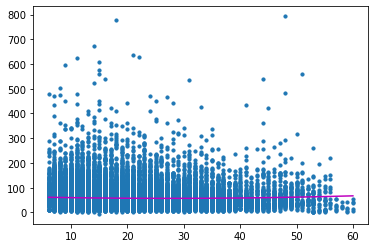

[64.16719215]
[[ 0.         -0.52600675  0.00960483]]
Degree: 3
rmse: 1882.638178862003
r2: 0.0009746586329975049


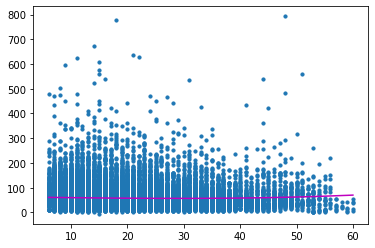

[62.78221415]
[[ 0.00000000e+00 -3.07931271e-01  1.49529035e-04  1.17296025e-04]]
uniqsubs
Degree: 1
rmse: 1884.2564195565124
r2: 0.00011593629303985331


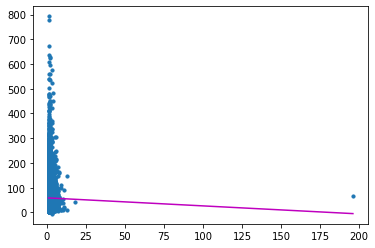

[59.05716408]
[[-0.32478984]]
Degree: 2
rmse: 1883.7585706009236
r2: 0.00038012073824578163


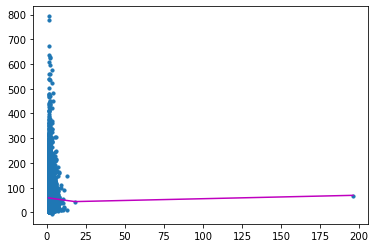

[60.0599069]
[[ 0.         -0.98676428  0.00527277]]
Degree: 3
rmse: 1883.1126337033033
r2: 0.0007228883166854327


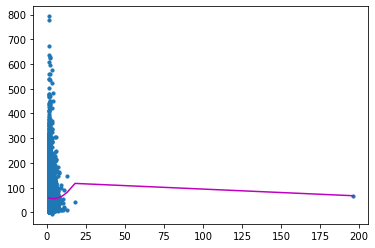

[61.87375598]
[[ 0.00000000e+00 -2.88495510e+00  3.63805146e-01 -1.78027914e-03]]
eqpdays
Degree: 1
rmse: 1787.9147424522766
r2: 0.05123982081720657


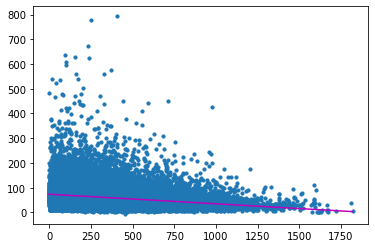

[73.63783404]
[[-0.03852516]]
Degree: 2
rmse: 1776.0075140960096
r2: 0.05755841299647757


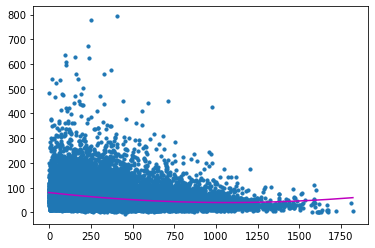

[80.32610324]
[[ 0.00000000e+00 -7.51692339e-02  3.50763511e-05]]
Degree: 3
rmse: 1771.3148252524807
r2: 0.060048596785626795


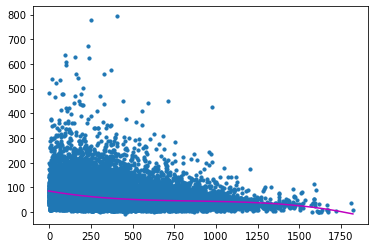

[84.92455864]
[[ 0.00000000e+00 -1.17559656e-01  1.23501111e-04 -4.76304189e-08]]
age2
Degree: 1
rmse: 1867.2440911165982
r2: 0.009143559029027415


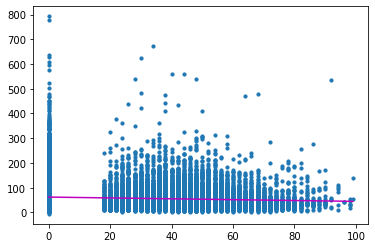

[62.20827136]
[[-0.17408772]]
Degree: 2
rmse: 1867.2244110056665
r2: 0.009154002315348908


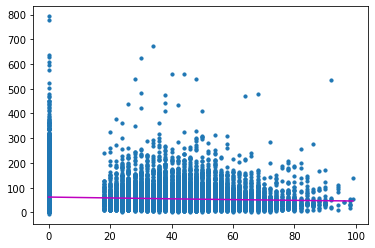

[62.25654818]
[[ 0.         -0.19164172  0.0003173 ]]
Degree: 3
rmse: 1866.9011436544044
r2: 0.009325544717693313


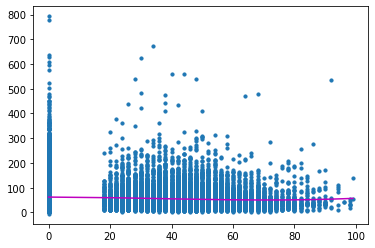

[62.17663334]
[[ 0.00000000e+00 -8.18754285e-03 -6.72967271e-03  6.34644777e-05]]
refer
Degree: 1
rmse: 1884.201453069851
r2: 0.000145104358214021


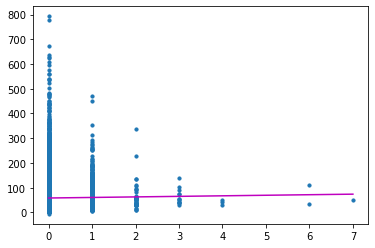

[58.44852975]
[[2.21725543]]
Degree: 2
rmse: 1884.1628636201517
r2: 0.00016558191921967058


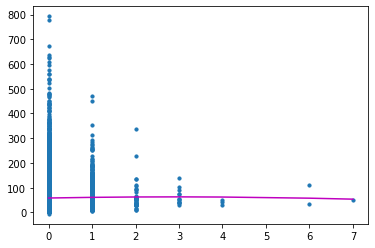

[58.43513642]
[[ 0.          3.16858458 -0.54762574]]
Degree: 3
rmse: 1884.1564183498188
r2: 0.0001690021135335451


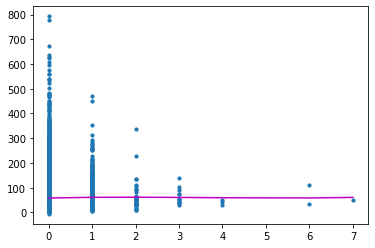

[58.43261328]
[[ 0.          4.12679931 -1.53202825  0.14168134]]


In [97]:
poly_cand = [x for x in selected_not_corr if x in continuous]

train_x1, test_x1, train_y1, test_y1 = train_test_split(df, labels, test_size = 0.25, random_state = 42)

train_x1 = train_x1.drop('revenue', axis = 1)
test_x1 = test_x1.drop('revenue', axis = 1)


for var in poly_cand:
    print(str(var))
    visual_poly(train_x1, train_y, var)

### Potential Polynomials:

overage: 2
changem: 2
changer: 2
incalls: 2
callwait: 2
threeway: 3


In [13]:
train_x['overage2']=train_x['overage']*train_x['overage']
train_x['changem2']=train_x['changem']*train_x['changem']
train_x['changer2']=train_x['changer']*train_x['changer']
train_x['incalls2']=train_x['incalls']*train_x['incalls']
train_x['callwait2']=train_x['callwait']*train_x['callwait']

train_x['threeway2']=train_x['threeway']*train_x['threeway']
train_x['threeway3']=train_x['threeway2']*train_x['threeway']


test_x['overage2']=test_x['overage']*test_x['overage']
test_x['changem2']=test_x['changem']*test_x['changem']
test_x['changer2']=test_x['changer']*test_x['changer']
test_x['incalls2']=test_x['incalls']*test_x['incalls']
test_x['callwait2']=test_x['callwait']*test_x['callwait']

test_x['threeway2']=test_x['threeway']*test_x['threeway']
test_x['threeway3']=test_x['threeway2']*test_x['threeway']

In [14]:
selected_not_corr = [x for x in train_x.columns if x not in drop_list]
OLS(train_x, test_x, train_y, test_y, selected = selected_not_corr)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     1737.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:05:29   Log-Likelihood:            -1.3075e+05
No. Observations:               29205   AIC:                         2.616e+05
Df Residuals:                   29151   BIC:                         2.621e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
directas       6.0035      0.136     44.069      0.0

### Decreasing Number of Variables with RFE:

In [15]:
remain = 20
selected_RFE = RFE_Elimination(train_x, train_y, remain, selected = selected_not_corr)

D:\Users\okaltun\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [16]:
selected_RFE = selected_RFE+ ['const']
selected_RFE

['mou',
 'directas',
 'overage',
 'roam',
 'changem',
 'changer',
 'dropvce',
 'blckvce',
 'custcare',
 'peakvce',
 'opeakvce',
 'dropblk',
 'months',
 'uniqsubs',
 'actvsubs',
 'eqpdays',
 'children',
 'credita',
 'creditaa',
 'refurb',
 'webcap',
 'occcler',
 'occcrft',
 'occstud',
 'occhmkr',
 'occself',
 'ownrent',
 'marryun',
 'marryyes',
 'mailord',
 'mailres',
 'mailflag',
 'creditcd',
 'newcelln',
 'incmiss',
 'income',
 'setprc',
 'retcall',
 'changer2',
 'const']

In [17]:
OLS(train_x, test_x, train_y, test_y, selected = selected_RFE)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     2813.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:05:54   Log-Likelihood:            -1.2878e+05
No. Observations:               29205   AIC:                         2.576e+05
Df Residuals:                   29165   BIC:                         2.580e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mou           13.5562      0.235     57.719      0.0

#### Polynomials made it even worse. Therefore I eliminated polynomials from my dataset.

In [27]:
train_x = train_x.drop(['overage2', 'changem2', 'changer2', 'incalls2', 'callwait2',
                       'threeway2', 'threeway3'], axis=1)

test_x = test_x.drop(['overage2', 'changem2', 'changer2', 'incalls2', 'callwait2',
                       'threeway2', 'threeway3'], axis=1)

selected_RFE = selected_RFE[0:-2] + ['const']

#### Initial MSE was 402, to beat that alternative models should be tried. Lasso & Ridge regressions are an option for penalizing variable effects:

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet

#### Whilst trying Lasso & Ridge regressions alpha parameter may change the results, so I conducted a grid search on alpha value:

In [30]:
parameters = {'alpha':[0.001, 0.01, 0.1, 1, 5, 20, 50, 100]}

lasso = Lasso()

lasso_regressor = GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=4)
lasso_regressor.fit(train_x, train_y)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

lasso_pred = lasso_regressor.predict(test_x.values)

print(metrics.mean_absolute_error(test_y, lasso_pred))
print(metrics.mean_squared_error(test_y, lasso_pred))

D:\Users\okaltun\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32124.98130528815, tolerance: 4054.7929601444694
  positive)
D:\Users\okaltun\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474819.8072686251, tolerance: 4106.191397142604
  positive)


{'alpha': 0.1}
-422.1685903801738
12.343302799658712
402.40340941644854


#### Trying the same with Ridge: Slightly better result in terms of MSE but still does not significantly beats OLS

In [33]:
parameters = {'alpha':[0.001, 0.01, 0.1, 1, 5, 20, 50, 100, 150, 200, 250, 500,1000, 10000]}

ridge = Ridge()

ridge_regressor = GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=4)
ridge_regressor.fit(train_x, train_y)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

ridge_pred = ridge_regressor.predict(test_x.values)

print(metrics.mean_absolute_error(test_y, ridge_pred))
print(metrics.mean_squared_error(test_y, ridge_pred))

{'alpha': 500}
-421.64823590961
12.369823746950601
401.5288879702815


#### Trying OLS and dropping insignificant p-values in the end

In [34]:
OLS(train_x, test_x, train_y, test_y, selected = selected_RFE)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     2815.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:26:25   Log-Likelihood:            -1.2937e+05
No. Observations:               29205   AIC:                         2.588e+05
Df Residuals:                   29167   BIC:                         2.591e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mou           13.4973      0.240     56.333      0.0

In [35]:
eliminate_list = ['changer','occcrft','occhmkr','occself','mailflag','incmiss']
train_x = train_x.drop(eliminate_list,axis=1)
test_x = test_x.drop(eliminate_list,axis=1)
selected_RFE = [x for x in selected_RFE if x not in eliminate_list]
OLS(train_x, test_x, train_y, test_y, selected = selected_RFE)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     3360.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:30:40   Log-Likelihood:            -1.2937e+05
No. Observations:               29205   AIC:                         2.588e+05
Df Residuals:                   29173   BIC:                         2.591e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mou           13.4983      0.240     56.348      0.0

In [36]:
el_2 = ['ownrent','marryun','mailres']
train_x = train_x.drop(el_2,axis=1)
test_x = test_x.drop(el_2,axis=1)
selected_RFE = [x for x in selected_RFE if x not in el_2]
OLS(train_x, test_x, train_y, test_y, selected = selected_RFE)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     3720.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:31:38   Log-Likelihood:            -1.2938e+05
No. Observations:               29205   AIC:                         2.588e+05
Df Residuals:                   29176   BIC:                         2.590e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mou           13.4939      0.240     56.328      0.0